<a href="https://colab.research.google.com/github/leonardo3108/IA368dd/blob/main/exercicios/Aula_6/Aula_6_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

* Treinar um modelo seq2seq (a partir do T5-base) na tarefa de expansão de documentos usando o doc2query
* Usar como treino o dataset "tiny" do MS MARCO na tarefa doc2query
https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv
* doc2query: A entrada é a passagem e o target é a query
Note que apenas pares (query, passagem relevante) são usados como treino.
O treino é relativamente rápido (<1 hora).
* Validar a cada X steps usando o sacreBLEU 
* A parte lenta deste exercício é a pré-indexação: para cada documento da coleção, temos que gerar uma ou mais queries, que depois são concatenadas ao documento original, e esse documento "expandido" é indexado.
* Avaliar no TREC-COVID (171K docs), pois é menor que o MS MARCO/TREC-DL 2020 (8.8M passagens). 
  * Indice invertido do Trec-covid no pyserini: beir-v1.0.0-trec-covid-flat
  * Corpus e queries na HF: https://huggingface.co/datasets/BeIR/trec-covid
  * qrels: https://huggingface.co/datasets/BeIR/trec-covid-qrels
  * Usar nDCG@10
  * Comparar com o BM25 com e sem os documentos expandidos pelo doc2query

# Setup

## Integração com Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparação de pastas

In [ ]:
!mkdir 'model_output'
!mkdir 'model_save'

In [ ]:
model_output_dir='model_output'
model_save_dir='model_save'

## Instalação de libs

In [ ]:
!pip install transformers
!pip install datasets
!pip install pyserini
!pip install faiss-gpu
!pip install evaluate
!pip install sacrebleu
!pip install trectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 30.8 MB/s eta 0:00:

## Importação de libs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import evaluate
import json
import torch
import os

from datasets import load_dataset
from pyserini.index import IndexReader
from pyserini.search import SimpleSearcher
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration,AutoModelForSeq2SeqLM, T5Config, AdamW, Adafactor
from pathlib import Path

## Utilização de GPUs

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [ ]:
if dev != 'cpu':
    !nvidia-smi

Wed Apr 12 01:47:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparação dos dados

## Obtenção

In [ ]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv

--2023-04-12 01:48:15--  https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8076179 (7.7M) [text/tab-separated-values]
Saving to: ‘msmarco_triples.train.tiny.tsv’

msmarco_triples.tra 100%[===================>]   7.70M  6.47MB/s    in 1.2s    

2023-04-12 01:48:16 (6.47 MB/s) - ‘msmarco_triples.train.tiny.tsv’ saved [8076179/8076179]



## Split

In [ ]:
df = pd.read_csv('msmarco_triples.train.tiny.tsv', delimiter="\t", header=None, names=['query', 'relevant_passage', 'non_relevant_passage'])
del df['non_relevant_passage']

df_valid = df.sample(1000)

df_train = df.drop(df_valid.index).reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

del df
len(df_train), len(df_valid)

(10000, 1000)

## Tokenizador

In [ ]:
model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


## Criação do Dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
       
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        query = self.df.loc[index, "query"]
        relevant_passage = self.df.loc[index, "relevant_passage"]

        tokenized_inputs = self.tokenizer( relevant_passage, return_tensors="pt", max_length=self.max_len, padding="max_length", truncation=True)
        tokenized_target = self.tokenizer( query, return_tensors="pt", max_length=self.max_len, padding="max_length", truncation=True).input_ids
        tokenized_target=torch.where(tokenized_target == 0, torch.tensor(-100, dtype=tokenized_target.dtype), tokenized_target)

        return {"input_ids": tokenized_inputs["input_ids"].squeeze(0), "attention_mask": tokenized_inputs["attention_mask"].squeeze(0), "labels": tokenized_target.squeeze(0)}


dataset_train = MyDataset(df_train, tokenizer, max_len=256)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = MyDataset(df_valid, tokenizer, max_len=256)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

# Treinamento

## Avaliação - Preparação

In [ ]:
sacrebleu_metric = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(preds, labels):
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
  
    result = sacrebleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    return result

## Execução

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to(device)

# optimizer = AdamW(model.parameters(), lr=2e-4)
optimizer = Adafactor(model.parameters(), relative_step=False,lr=2e-4)
epochs = 10
during_training_metrics=[]

model.train()
for epoch in range(epochs):
    for step, batch in tqdm(enumerate(dataloader_train), total=len(dataloader_train), desc=f"epoch {epoch}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    acc={
        "bleu":0,
        "val_loss": 0
    }
    with torch.no_grad():
      for val_batch in tqdm(dataloader_val, total=len(dataloader_val), desc="evaluating"):
        input_ids = val_batch["input_ids"].to(device)
        attention_mask = val_batch["attention_mask"].to(device)
        labels = val_batch["labels"]

        gen_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        metric_result=compute_metrics(gen_ids, labels)
        
        labels = val_batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        metric_result["val_loss"] = outputs.loss.cpu().item()

        for metric in acc:
          acc[metric]+=metric_result[metric]
      
      for metric in acc:
        acc[metric]=acc[metric]/len(dataloader_val)

      acc["train_loss"]= loss.cpu().item()
      during_training_metrics.append(acc)
      print(acc)

    save_path=Path(model_save_dir, "train", f"epoch_{epoch}")
    os.makedirs(save_path.parent, exist_ok=True)
    model.save_pretrained(save_path)

evaluating:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
evaluating: 100%|██████████| 32/32 [01:34<00:00,  2.95s/it]


{'bleu': 13.251061470453948, 'val_loss': 1.7305664531886578, 'train_loss': 1.6640379428863525}


evaluating: 100%|██████████| 32/32 [01:32<00:00,  2.89s/it]


{'bleu': 13.978141043862545, 'val_loss': 1.6659501753747463, 'train_loss': 1.46916663646698}


evaluating: 100%|██████████| 32/32 [01:33<00:00,  2.92s/it]


{'bleu': 15.144014106211088, 'val_loss': 1.6163758859038353, 'train_loss': 1.5808879137039185}


evaluating: 100%|██████████| 32/32 [01:33<00:00,  2.91s/it]


{'bleu': 14.941244419523603, 'val_loss': 1.6055990643799305, 'train_loss': 1.3759629726409912}


evaluating: 100%|██████████| 32/32 [01:33<00:00,  2.92s/it]


{'bleu': 15.10942556792968, 'val_loss': 1.6048212498426437, 'train_loss': 1.2356274127960205}


evaluating: 100%|██████████| 32/32 [01:33<00:00,  2.92s/it]


{'bleu': 14.972555508972414, 'val_loss': 1.6158753857016563, 'train_loss': 1.3976680040359497}


evaluating: 100%|██████████| 32/32 [01:32<00:00,  2.91s/it]


{'bleu': 14.711260605926812, 'val_loss': 1.6049908138811588, 'train_loss': 0.9760748744010925}


evaluating: 100%|██████████| 32/32 [01:33<00:00,  2.92s/it]


{'bleu': 16.132800008441304, 'val_loss': 1.621082667261362, 'train_loss': 1.2661972045898438}


evaluating: 100%|██████████| 32/32 [01:33<00:00,  2.91s/it]


{'bleu': 15.07755956520143, 'val_loss': 1.626434002071619, 'train_loss': 1.0960313081741333}


evaluating: 100%|██████████| 32/32 [01:33<00:00,  2.93s/it]


{'bleu': 15.988163640981579, 'val_loss': 1.6522530876100063, 'train_loss': 0.7592186331748962}


## Avaliação - Visualização 

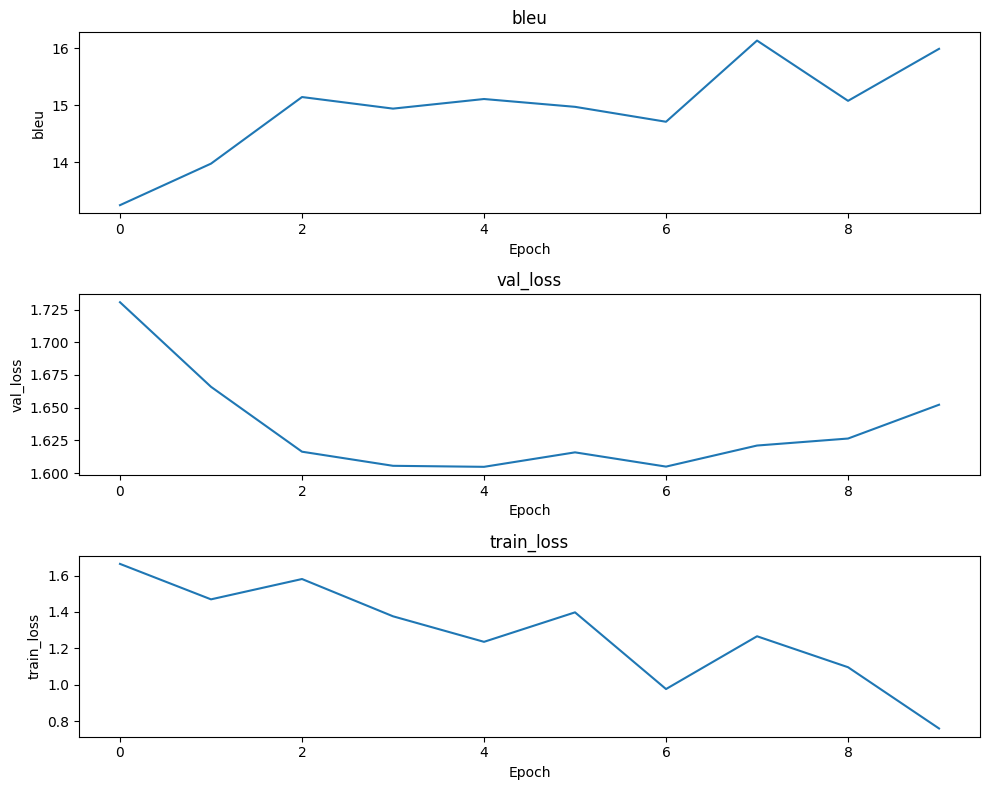

In [ ]:
# Define the metrics to plot
metrics = ["bleu", "val_loss", "train_loss"]

# Plot each metric in a separate subplot
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 8))
for i, metric in enumerate(metrics):
    axs[i].plot([x[metric] for x in during_training_metrics])
    axs[i].set_title(metric)
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel(metric)
plt.tight_layout()
plt.show()